# Uncertainty 

This is a tutorial for the uncertainty module.

In [3]:
import numpy as np
import os
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
from pathos.pools import ProcessPool as Pool
import numpy as np

from climada import util
util.config.setup_logging("ERROR")

from climada.engine.uncertainty import UncVar, UncSensitivity
from climada.entity import BlackMarble, ImpactFunc, ImpactFuncSet
from climada.hazard import TropCyclone
from climada.util.value_representation import value_to_monetary_unit as vtm
from climada.util.plot import multibar_plot

In [4]:
def imp_fun_tc(G=1, v_half=84.7, vmin=25.7, k=3, _id=1):    
    imp_fun = ImpactFunc()
    imp_fun.haz_type = 'TC'
    imp_fun.id = _id
    imp_fun.intensity_unit = 'm/s'
    imp_fun.intensity = np.linspace(0, 150, num=100)
    imp_fun.mdd = np.repeat(1, len(imp_fun.intensity))
    imp_fun.paa = np.array([sigmoid_func(v, G, v_half, vmin, k) for v in imp_fun.intensity])
    imp_fun.check()
    impf_set = ImpactFuncSet()
    impf_set.append(imp_fun)
    return impf_set

def xhi(v, v_half, vmin):
    return max([(v - vmin), 0]) / (v_half - vmin)
  
def sigmoid_func(v, G, v_half, vmin, k):
    return G * xhi(v, v_half, vmin)**k / (1 + xhi(v, v_half, vmin)**k)

CURR_DIR = "/Users/ckropf/Documents/Climada/Uncertainty"

def dummy_exp():
    file_name = os.path.join(CURR_DIR, "exp_AIA.h5")
    exp = BlackMarble()
    exp.read_hdf5(file_name)
    return exp
    
def dummy_haz():
    file_name = os.path.join(CURR_DIR, "tc_AIA.h5")
    haz= TropCyclone()
    haz.read_hdf5(file_name)
    return haz

In [5]:
exp = dummy_exp()
haz = dummy_haz()
impf = imp_fun_tc

distr_dict = {"G": sp.stats.uniform(0.8,1),
              "v_half": sp.stats.uniform(50, 100),
              "vmin": sp.stats.uniform(15,30),
              "k": sp.stats.uniform(1, 5)
              }

impf_unc = UncVar(impf, distr_dict)

unc = UncSensitivity(exp, impf_unc, haz)
imp_sobol_dict = unc.calc_impact_sobol_sensitivity(N=100, calc_eai_exp=False, calc_at_event=False, calc_second_order=True)

/Users/ckropf/Documents/Climada/climada_python/climada/engine/uncertainty.py:432: RuntimeWarning: invalid value encountered in less
  if np.any(np.array(si_list)<0):


In [ ]:
#With parralel computation
exp = dummy_exp()
haz = dummy_haz()
impf = imp_fun_tc

distr_dict = {"G": sp.stats.uniform(0.8,1),
              "v_half": sp.stats.uniform(50, 100),
              "vmin": sp.stats.uniform(15,30),
              "k": sp.stats.uniform(1, 5)
              }

impf_unc = UncVar(impf, distr_dict)

pool = Pool()
unc = UncSensitivity(exp, impf_unc, haz, pool=pool)
imp_sobol_dict = unc.calc_impact_sobol_sensitivity(N=100, calc_eai_exp=False, calc_at_event=False, calc_second_order=True)
pool.close()
pool.join()

In [6]:
S1_aai_agg = { k:list(imp_sobol_dict['aai_agg'][k]) for k in ['S1', 'S1_conf', 'ST', 'ST_conf']}

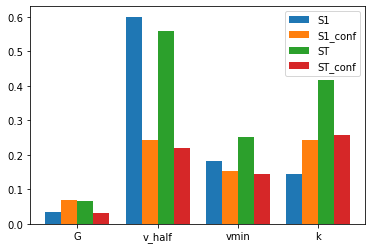

In [8]:
fig, ax = plt.subplots()
multibar_plot(ax, S1_aai_agg)
plt.setp(ax, xticks=range(len(unc.params.columns.to_list())), xticklabels=unc.params.columns.to_list());

In [10]:
all_S1 = {in_var: list(imp_sobol_dict[in_var]['S1']) for in_var in imp_sobol_dict.keys()}

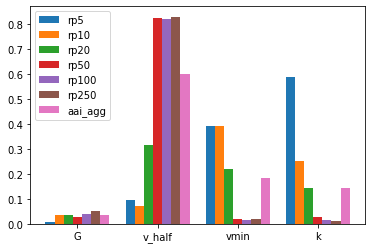

In [11]:
fig, ax = plt.subplots()
multibar_plot(ax, all_S1)
plt.setp(ax, xticks=range(len(unc.params.columns.to_list())), xticklabels=unc.params.columns.to_list());

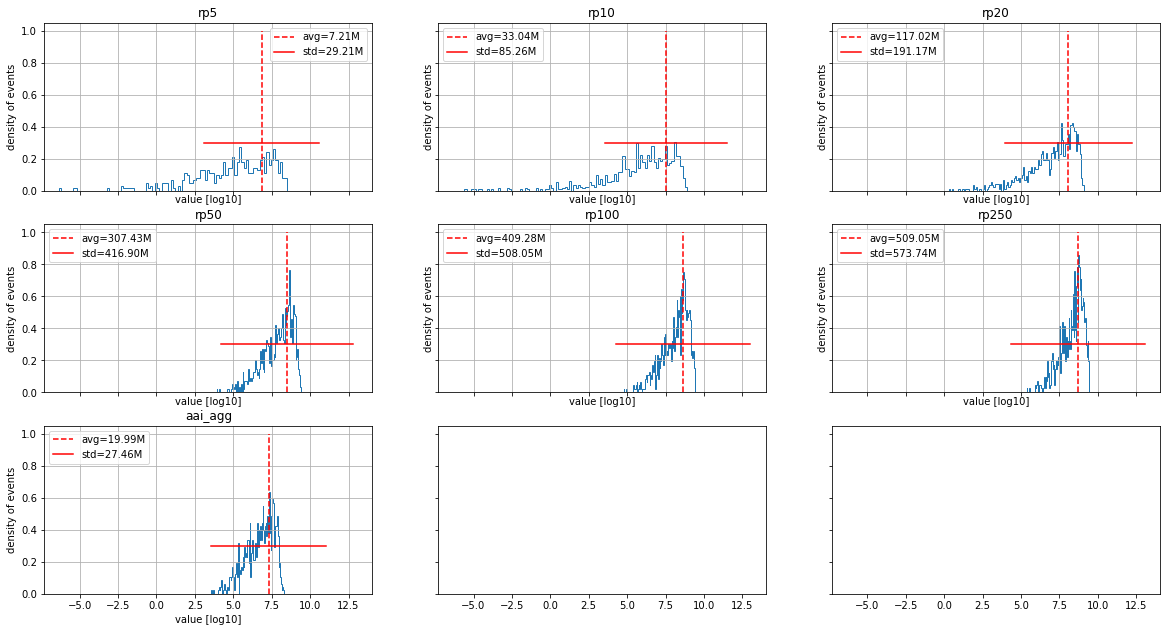

In [12]:
unc.plot_uncertainty();